# Plane stress with finite elements

For the example cantilever problem in plane stress, the overall algorithm to assemble and solve the finite element system is as follows:

1. Discretize the domain into finite element cells (e.g., triangles).
2. Introduce local and global numbering of degrees of freedom.
3. Loop over all elements/cells to assemble the global stiffness matrix and force vector by performing for each element:
     1. compute the Jacobian of the mapping from reference to physical element,
     2. compute the determinant and inverse transpose of the Jacobian,
     3. compute the derivatives of basis functions in physical coordinates using the inverse transpose Jacobian,
     4. compute the element stiffness matrix and force vector using numerical integration (e.g., a quadrature on triangles),
     5. assemble the element contributions into the global stiffness matrix and force vector.
4. Apply displacement boundary conditions by splitting the system into free and fixed degrees of freedom.
5. Solve the resulting linear system for the unknown displacements $\mathbf u$ and $\mathbf v$.


### 1. Discretize the domain into triangles

In [1]:
import numpy as np

In [2]:
H = 0.5
L = 2.0
geometry = np.array([[0,0],
                     [L/2, 0],
                     [L, 0],
                     [0, H/2],
                     [L/2, H/2],
                     [L, H/2],
                     [0, H],
                     [L/2, H],
                     [L, H]])
topology = np.array([[3, 0, 4],
                     [0, 1, 4],
                     [1, 5, 4],
                     [1, 2, 5],
                     [5, 8, 4],
                     [4, 8, 7],
                     [3, 4, 7],
                     [3, 7, 6]])

num_vertices = geometry.shape[0]

In [3]:
import matplotlib.tri

triangulation = matplotlib.tri.Triangulation(geometry[:, 0], geometry[:, 1], topology)

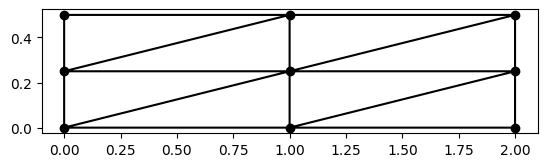

In [4]:
import matplotlib.pyplot as plt

plt.gca().set_aspect("equal")
plt.triplot(triangulation, marker="o", color="black")

As a part of the mesh/domain discretization we need to prepare the reference to physical affine mapping
$$F^{(e)}([\xi, \eta]^T) = [x, y]^T$$
which takes a point $\mathbf{\hat x} = [\xi, \eta]^T$ in the reference triangle (with vertices $[0,0], [1, 0], [0, 1]$) and returns a point in the triangle in the actual, physical domain $\mathbf x = [x, y]^T$.

**This mapping is different for each element $e$!**

For any point $\mathbf{x}$ in a triangle with three vertices $\mathbf x_0, \mathbf x_1$ and $\mathbf x_2$ there is
$$\mathbf{x} =  (1 - \xi - \eta) \mathbf x_0 + \xi \mathbf x_1 + \eta \mathbf x_2.$$

tri
 [4 8 7]
tri_geometry
 [[1.   0.25]
 [2.   0.5 ]
 [1.   0.5 ]]


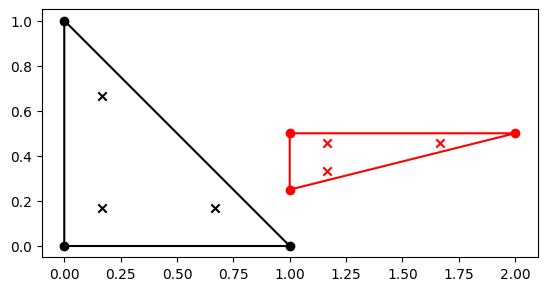

In [5]:
def F(vertices, xhat):
    xi = xhat.T[0]
    eta = xhat.T[1]
    return np.outer((1 - xi - eta), vertices[0]) + np.outer(xi, vertices[1]) + np.outer(eta, vertices[2])


reference_triangle = np.array([[0.0, 0.0], [1.0, 0], [0.0, 1.0]])
reference_points = np.array([[1/6, 1/6], [2/3, 1/6], [1/6, 2/3]])
plt.gca().set_aspect("equal")
plt.triplot(reference_triangle[:, 0], reference_triangle[:, 1], [[0, 1, 2]], marker="o", color="black")
plt.scatter(reference_points[:, 0], reference_points[:,1], color="black", marker="x")

n = 5
tri = topology[n]
tri_geometry = geometry[tri]
print("tri\n", tri)
print("tri_geometry\n", tri_geometry)

physical_triangle = F(tri_geometry, reference_triangle)
physical_points = F(tri_geometry, reference_points)

plt.triplot(physical_triangle[:, 0], physical_triangle[:, 1], [[0, 1, 2]], marker="o", color="red")
plt.scatter(physical_points[:, 0], physical_points[:, 1], color="red", marker="x")

### 2. Introduce local and global numbering of degrees of freedom

We need to build the degrees-of-freedom numbering. What we want is an array, that for each triangle will store the global indices of DoFs
for all 6 unknown displacements (2 components for 3 vertices each).

Numbering is our choice, but we need to encode the **continuity** of displacements there. What we can choose is if we interleave the DoFs.

In [6]:
dofmap = np.hstack((topology, topology + num_vertices))
print(f"Non-interleaved dofmap:\n{dofmap}")

Non-interleaved dofmap:
[[ 3  0  4 12  9 13]
 [ 0  1  4  9 10 13]
 [ 1  5  4 10 14 13]
 [ 1  2  5 10 11 14]
 [ 5  8  4 14 17 13]
 [ 4  8  7 13 17 16]
 [ 3  4  7 12 13 16]
 [ 3  7  6 12 16 15]]


In [7]:
def u0(xi, eta):
    return (1 - xi - eta)

def u1(xi, eta):
    return xi

def u2(xi, eta):
    return eta

def du0dxi(xi, eta):
    return -1.0

def du0deta(xi, eta):
    return -1.0

def du1dxi(xi, eta):
    return 1.0

def du1deta(xi, eta):
    return 0.0

def du2dxi(xi, eta):
    return 0.0

def du2deta(xi, eta):
    return 1.0

def basis_deriv(xi, eta):
    return np.array([[du0dxi(xi, eta), du1dxi(xi, eta), du2dxi(xi, eta)],
                     [du0deta(xi, eta), du1deta(xi, eta), du2deta(xi, eta)]])

print(basis_deriv(1/3,1/3))

basis = [u0, u1, u2]

[[-1.  1.  0.]
 [-1.  0.  1.]]


### 3. Loop over all elements/cells to assemble the global stiffness matrix and force vector by performing for each element

1. compute the Jacobian of the mapping from reference to physical element,
2. compute the determinant and inverse transpose of the Jacobian,
3. compute the derivatives of basis functions in physical coordinates using the inverse transpose Jacobian,
4. compute the element stiffness matrix and force vector using numerical integration (e.g., a quadrature on triangles),
5. assemble the element contributions into the global stiffness matrix and force vector.

We'll prepare Jacobian of the reference to physical mapping. Jacobian is defined as
$$\mathbf J = \frac{\partial \mathbf F}{\partial \mathbf{\hat x}}, \quad \text{ in components } J_{ij} = \frac{F_i}{\hat x_j},$$
which then for the affine mapping from above is
\begin{equation}
J_{ij} =
\begin{bmatrix}
\frac{\partial}{\partial \xi} \left((1 - \xi - \eta)x_{00} + \xi x_{10} + \eta x_{20}\right) & \frac{\partial}{\partial \eta} \left((1 - \xi - \eta)x_{00} + \xi x_{10} + \eta x_{20}\right)\\
\frac{\partial}{\partial \xi} \left((1 - \xi - \eta)x_{01} + \xi x_{11} + \eta x_{21}\right) & \frac{\partial}{\partial \eta} \left((1 - \xi - \eta)x_{01} + \xi x_{11} + \eta x_{21}\right)
\end{bmatrix} =
\begin{bmatrix}
-x_{00} + x_{10} & -x_{00} + x_{20}\\
-x_{01} + x_{11} & -x_{01} + x_{21}
\end{bmatrix} = 
\begin{bmatrix}
\mathbf x_1 - \mathbf x_0 & \mathbf x_2 - \mathbf x_0
\end{bmatrix}.
\end{equation}

The Jacobian of the affine (linear) mapping is constant wrt. $\xi, \eta$, so does not depend on it.


In [8]:
def J(vertices):
    return np.vstack((vertices[1] - vertices[0], vertices[2] - vertices[0])).T

In [9]:
num_triangles = topology.shape[0]
print(f"Number of triangles: {num_triangles}")


E = 70 * 1e+9
nu = 0.33
h = 0.01
C = E / (1 - nu**2) * np.array([[1, nu, 0],
                                [nu, 1, 0],
                                [0, 0, (1 - nu) / 2]])

quadrature_point = np.array([1/3, 1/3])
quadrature_weights = np.array([1/2])

num_global_dofs = 2 * num_vertices
K = np.zeros((num_global_dofs, num_global_dofs))


def K_local(vertices):
    J_local = J(vertices)
    detJ = np.linalg.det(J_local)
    basis_deriv_local = basis_deriv(quadrature_point[0], quadrature_point[1])

    basis_deriv_physical = np.linalg.inv(J_local).T @ basis_deriv_local
    B0 = np.array([[basis_deriv_physical[0, 0], 0.0],
                   [0.0, basis_deriv_physical[1, 0]],
                   [basis_deriv_physical[1, 0], basis_deriv_physical[0, 0]]])   
    B1 = np.array([[basis_deriv_physical[0, 1], 0.0],
                   [0.0, basis_deriv_physical[1, 1]],
                   [basis_deriv_physical[1, 1], basis_deriv_physical[0, 1]]]) 
    B2 = np.array([[basis_deriv_physical[0, 2], 0.0],
                   [0.0, basis_deriv_physical[1, 2]],
                   [basis_deriv_physical[1, 2], basis_deriv_physical[0, 2]]])

    B = np.block([B0, B1, B2])
    BTCB = detJ*h*quadrature_weights[0] * B.T@C@B

    perm = np.array([0, 2, 4, 1, 3, 5]) 
    return BTCB[np.ix_(perm, perm)]


for i in range(num_triangles):
    vertices = geometry[topology[i]]
    cell_dofmap = dofmap[i]

    K_loc = K_local(vertices)
    K[np.ix_(cell_dofmap, cell_dofmap)] += K_loc

Number of triangles: 8


### 4. Boundary conditions

In the problem definition, there are two types of boundary conditions applied in the problem:

1. Dirichlet (kinematic, displacement, strong) boundary conditions on the left edge that prescribe
   that both $x$ and $y$ components of the displacements must be 0 (clamped),
2. Neumann (static, force) boundary conditions on the right edge prescribing a force vector $\mathbf q$.


Dirichlet boundary conditions are applied via the split of degree-of-freedom into the "free" and "prescribed".
We can inspect the numering to figure out which degrees of freedom belong to the left edge.

There are 12 free dofs and 6 Dirichlet dofs.


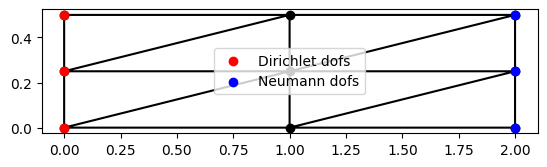

In [10]:
dirichlet_dofs_x = np.array([0, 3, 6])
dirichlet_dofs_y = dirichlet_dofs_x + num_vertices
dirichlet_dofs_xy = np.hstack((dirichlet_dofs_x, dirichlet_dofs_y))

neumann_dofs = np.array([2, 5, 8]) + num_vertices

free_dofs = np.setdiff1d(np.arange(num_global_dofs, dtype=np.int32), dirichlet_dofs_xy)
print(f"There are {len(free_dofs)} free dofs and {len(dirichlet_dofs_xy)} Dirichlet dofs.")

plt.gca().set_aspect("equal")
plt.triplot(triangulation, marker="o", color="black")
plt.scatter(geometry[dirichlet_dofs_x, 0], geometry[dirichlet_dofs_x, 1], color="red", zorder=2, label="Dirichlet dofs")
plt.scatter(geometry[neumann_dofs - num_vertices, 0], geometry[neumann_dofs - num_vertices, 1], color="blue", zorder=2, label="Neumann dofs")
plt.legend(loc="center")

In [11]:
K_f = K[np.ix_(free_dofs, free_dofs)]
f = np.zeros(num_global_dofs)
q = -1e+4 / len(neumann_dofs)
f[neumann_dofs] = q
f_f = f[free_dofs]
u_f = np.linalg.solve(K_f, f_f)

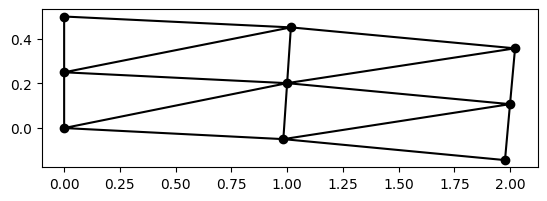

In [12]:
dof_to_coordinate = np.array([0, 2, 4, 6, 8, 10, 12, 14, 16, 1, 3, 5, 7, 9, 11, 13, 15, 17])
deformed_geometry = geometry.copy()
scale = 200
deformed_geometry.flat[dof_to_coordinate[free_dofs]] += scale * u_f

plt.gca().set_aspect("equal")
plt.triplot(deformed_geometry[:, 0], deformed_geometry[:, 1], topology, marker="o", color="black")

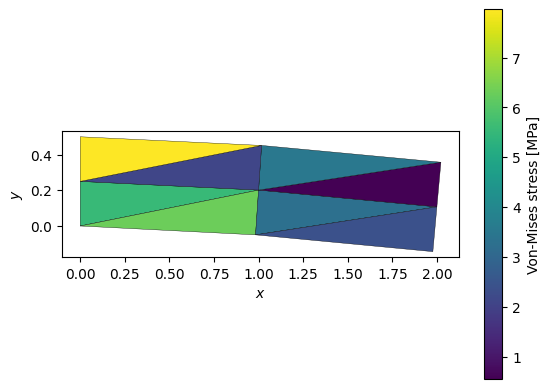

In [13]:
def stress(vertices, u_local):
    J_local = J(vertices)
    detJ = np.linalg.det(J_local)
    basis_deriv_local = basis_deriv(quadrature_point[0], quadrature_point[1])

    basis_deriv_physical = np.linalg.inv(J_local).T @ basis_deriv_local
    B0 = np.array([[basis_deriv_physical[0, 0], 0.0],
                   [0.0, basis_deriv_physical[1, 0]],
                   [basis_deriv_physical[1, 0], basis_deriv_physical[0, 0]]])   
    B1 = np.array([[basis_deriv_physical[0, 1], 0.0],
                   [0.0, basis_deriv_physical[1, 1]],
                   [basis_deriv_physical[1, 1], basis_deriv_physical[0, 1]]]) 
    B2 = np.array([[basis_deriv_physical[0, 2], 0.0],
                   [0.0, basis_deriv_physical[1, 2]],
                   [basis_deriv_physical[1, 2], basis_deriv_physical[0, 2]]]) 

    B = np.block([B0, B1, B2])
    perm = np.array([0, 3, 1, 4, 2, 5])
    u_local = u_local[perm]
    
    S = C@B@u_local
    return von_mises(S[0], S[1], S[2] / 2)


u = np.zeros(num_global_dofs)
u[free_dofs] = u_f

def von_mises(S_xx, S_yy, S_xy):
    return np.sqrt(S_xx**2 - S_xx*S_yy + S_yy**2 + 3*S_xy**2)


vm = np.zeros(8)
for i in range(num_triangles):
    vertices = geometry[topology[i]]
    u_local = u[dofmap[i]]  
    vm[i] = stress(vertices, u_local)

fig1, ax1 = plt.subplots()
ax1.set_aspect('equal')
tpc = ax1.tripcolor(deformed_geometry[:, 0], deformed_geometry[:, 1], vm / 1e+6, edgecolor="black", triangles=topology)
ax1.set_xlabel("$x$")
ax1.set_ylabel("$y$")
fig1.colorbar(tpc, label="Von-Mises stress [MPa]")
